In [1]:
!pip install keras

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, Flatten
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from tifffile import imread, imwrite
import random
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
def augment(ims, labs):
    x = []
    y = []
    for i in range(0, len(ims)):
        r90 = np.rot90(ims[i])
        r180 = np.rot90(r90)
        r270 = np.rot90(r180)
        x.append(ims[i])
        x.append(r90)
        x.append(r180)
        x.append(r270)
        x.append(np.flipud(ims[i]))
        x.append(np.fliplr(ims[i]))
        x.append(np.flipud(r90))
        x.append(np.flipud(r180))
        for j in range(0, 8):
            y.append(labs[i])
    return [np.asarray(x), np.asarray(y)]

In [7]:
def read_segs(path):
    ims = []
    labels = []
    for classname in listdir(path):
        classpath = os.path.join(path, classname)
        for i, file in enumerate(listdir(classpath)):
            if(i >= 90):
                break
            seg = imread(os.path.join(classpath, file))
            ims.append(seg)
            labels.append(classname)

    tup = [np.array(ims), np.array(labels)]
    return tup

In [8]:
# def main():
## Based on this tutorial:
##    https://medium.com/@sandy_lee/how-to-train-neural-networks-for-image-classification-part-1-21327fe1cc1

## path to labeled sets
path = 'p3chunks/'

## 80% of data for training
train_test_split = .9

## 10% of training data for validation
validation_split = .2

data = read_segs(path)
ims = data[0]
labels = data[1]

print(len(ims))
lookupTable, idx,  labels, counts = np.unique(labels, return_inverse=True, return_counts=True, return_index=True)
print(len(lookupTable))
print(counts)


270
3
[90 90 90]


(2160, 30, 30, 4)
(2160,)
Epoch 1/100
49/49 [==============================] - 5s 87ms/step - loss: 4.9599 - accuracy: 0.4269 - val_loss: 0.8986 - val_accuracy: 0.6144
Epoch 2/100
49/49 [==============================] - 3s 71ms/step - loss: 0.8986 - accuracy: 0.5523 - val_loss: 0.7971 - val_accuracy: 0.6812
Epoch 3/100
49/49 [==============================] - 3s 71ms/step - loss: 1.7412 - accuracy: 0.5267 - val_loss: 0.9768 - val_accuracy: 0.4987
Epoch 4/100
49/49 [==============================] - 4s 75ms/step - loss: 0.9340 - accuracy: 0.5450 - val_loss: 0.9376 - val_accuracy: 0.4910
Epoch 5/100
49/49 [==============================] - 3s 67ms/step - loss: 0.9343 - accuracy: 0.4587 - val_loss: 0.9135 - val_accuracy: 0.5116
Epoch 6/100
49/49 [==============================] - 3s 69ms/step - loss: 0.8863 - accuracy: 0.5891 - val_loss: 0.8453 - val_accuracy: 0.5090
Epoch 7/100
49/49 [==============================] - 3s 67ms/step - loss: 0.8169 - accuracy: 0.6834 - val_loss: 1.5515 - v

49/49 [==============================] - 3s 66ms/step - loss: 0.0099 - accuracy: 0.9978 - val_loss: 0.0136 - val_accuracy: 0.9974
Epoch 59/100
49/49 [==============================] - 3s 65ms/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 60/100
49/49 [==============================] - 4s 72ms/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 61/100
49/49 [==============================] - 4s 73ms/step - loss: 0.0114 - accuracy: 0.9972 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 62/100
49/49 [==============================] - 3s 69ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 63/100
49/49 [==============================] - 3s 68ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 64/100
49/49 [==============================] - 3s 71ms/step - loss: 0.0061 - accuracy: 0.9996 - val_loss: 0.0116 - val_accuracy: 0.9974
Epoch 65/100

/Users/mAC/opt/anaconda3/envs/py3.8/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


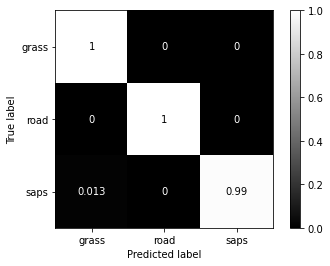

INFO:tensorflow:Assets written to: model/assets
216


In [9]:
##  Makes string labels into ints

## Adds data
x, y = augment(ims, labels)

## Shuffles data
idx = np.random.permutation(len(x))
X,Y = x[idx], y[idx]

x_train, x_test= X[:int(X.shape[0]*train_test_split)], X[int(X.shape[0]*train_test_split):]
y_train, y_test = Y[:int(Y.shape[0]*train_test_split)], Y[int(Y.shape[0]*train_test_split):]

## Scales data from 0-255 to 0-1, surprisingly important for some reason
# x_train, x_test = x_train/ 256., x_test/ 256.
print(X.shape)
print(Y.shape)


## Neural net, copied structure from tutorial

model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(30,30,4)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

#     model = keras.models.Sequential([keras.layers.Flatten(input_shape = [30,30,4]), #keras.layers.Flatten(input_shape = [2,2,4]
#         # keras.layers.Dense(2251, activation = 'relu' ),
#         keras.layers.Dense(500, activation = 'relu' ),
#         # keras.layers.Dense(100, activation = 'relu' ),
#         keras.layers.Dense(100, activation = 'relu' ),
#         keras.layers.Dense(100, activation = 'relu' ),
#         keras.layers.Dense(len(lookupTable), activation = 'softmax' )])
#     #

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), #change for tf v1 compat

    # optimizer = 'RMSprop',  #.9-.97
    # optimizer = 'Adam',     #.95-.97
    # optimizer = 'Adamax',   #.95-.97
    optimizer = 'Nadam',    #.97-.98
    metrics = ['accuracy']
)

# model.compile(loss=cc_from_logits)


# model.compile(loss=customLoss, optimizer='adam', metrics=['sparse_categorical_accuracy', 'categorical_accuracy'])

history = model.fit(x_train, y_train, epochs = 100, validation_split=validation_split)

print("Evaluating: \n\n\n")
metrics = model.evaluate(x_test, y_test)

y_pred = model.predict_classes(x_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred.round(), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lookupTable)
disp = disp.plot(cmap='gray')
plt.show()

if metrics[1] > .99:
    model.save('model/')

print(len(y_test))



